# PROJECT 2  -  PART II   - SPY ETF

Build an RNN LSTM for predicting ETF prices using time-series data and evaluate performance of a trading stategy based on LSTM forecasted price with that of classical MA driven strategy.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path

import hvplot.pandas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


from finta import TA

%matplotlib inline


# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


Bad key savefig.frameon in file /Users/adnanquaderi/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/adnanquaderi/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/adnanquaderi/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout

## Set Seed for reproducibility

In [2]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
import tensorflow as tf
import tensorflow.keras.backend as K

K.clear_session()
tf.keras.backend.clear_session()
np.random.seed(2)
tf.random.set_seed(2)


In [3]:
import os
from dotenv import load_dotenv
load_dotenv('penn.env')
import requests
quandl_key = os.getenv("QUANDL_KEY")

In [4]:
# Setting these options will allow for reviewing more of the DataFrames
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)

Import Classification Libraries

In [5]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [6]:
#Set Processor to Run computations in backend
print(tf.config.list_physical_devices(device_type=None))
tf.config.optimizer.set_jit(True)
gpus = tf.config.list_physical_devices('XLA_CPU') #Our normal laptops have Accelerated Linear Algebra Processor (XLA) activate it through C API
if gpus:
  # Restrict TensorFlow to only use some XLA_CPU
    try:
        tf.config.experimental.set_visible_devices(gpus[:], 'XLA_CPU')
        logical_gpus = tf.config.experimental.list_logical_devices('XLA_CPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
        print('used: {}% free: {:.2f}GB'.format(psutil.virtual_memory().percent, float(psutil.virtual_memory().free)/1024**3))#@ 
    except RuntimeError as e:
    # Visible devices must be set at program startup
        print(e)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Instructions

### Initial Setup

To ensure models' reproducibility, set the random seed for `numpy` and `tensorflow` libraries.


### Data Preparation  - API is not used for this portoion of project but is elswhere; code retained for future re-use.  
In this section data will be read in from csv files and converted to panadas dataframe for use. 


##########################################################################################################################################

#### Data Retrieval

In this section, there is placehold code to retrieve Gold historical prices from the London Bullion Market Association using the [Quandl API](https://www.quandl.com/data/LBMA/GOLD-Gold-Price-London-Fixing).

Import  Quandl API key from an environment variable named `quandl_key`.

In [ ]:
# # Import the API key for QUANDL
# import os
# from pathlib import Path
# from dotenv import load_dotenv
# load_dotenv('penn.env')
# quandl_key = os.getenv("QUANDL_KEY")

In [ ]:
# print(quandl_key)

Open the ["Gold Price: London Fixing" at the Quandl website](https://www.quandl.com/data/LBMA/GOLD-Gold-Price-London-Fixing), and set the URL to retrieve the historical prices of gold in `json` format.

In [ ]:
# # Set Gold price URL
# request_url = "https://www.quandl.com/api/v3/datasets/LBMA/GOLD.json?api_key="

# gold_prices_url = request_url + quandl_key

Use the `requests` library to retrieve the historical prices of gold in `json` format.

In [ ]:
# # Fetch Gold prices from QUANDL
# import requests
# # 
# # response_data = requests.get(gold_prices_url).json()

Explore the `json` response data and create a Pandas DataFrame containing the historical prices of gold in all the different currencies provided by the API, and set the data as the index of the DataFrame.

DataFrame should look like the following sample:


![Sample gold prices DataFrame](../Images/sample-gold-prices-df.png)

**Note:** While working with time-series data, it's important to transform dates data to `datetime` data type explicitly. R
    Can reveiw [Quandl API documentation for time-series data](https://docs.quandl.com/docs/time-series) if needed.
    
    

In [ ]:
# Explore the `response_data` object

# Fetch the keys of the `response_data` object
# response_data.keys()


In [ ]:
# Explore the contents of the main key
# response_data["dataset"]

In [ ]:
# # Create a DataFrame with Gold prices
# # gold_df = pd.DataFrame(
# #     response_data["dataset"]["data"], 
# #     columns=response_data["dataset"]["column_names"],
# # )

# #Transform the "Date" column to datetime
# gold_df['Date']= pd.to_datetime(gold_df['Date'])

# # Set the "Date" column as the DataFrame Index
# gold_df.set_index("Date", inplace=True)

# # # Show the DataFrame head
# # gold_df.head()

##############################################################################################################

##  Read csv file and convert to dataframe  - Data Processing Starts here

In [7]:
# Import the apple dataset into a Pandas Dataframe
df_read = pd.read_csv(
    Path("spy2_short.csv"), 
    index_col=0, 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
df = df_read.copy()
df.head()

close     volume    open    high      low
date                                                  
2015-01-02  205.43  121465865  206.38  206.88  204.180
2015-01-05  201.72  169632646  204.17  204.37  201.350
2015-01-06  199.82  209151408  202.09  202.72  198.855
2015-01-07  202.31  125346709  201.42  202.72  200.880
2015-01-08  205.90  147217784  204.01  206.16  203.990

In [8]:
df.tail()

close    volume    open    high     low
date                                                
2021-12-27  477.26  56808619  472.06  477.31  472.01
2021-12-28  476.87  47274585  477.72  478.81  476.06
2021-12-29  477.48  54502964  476.98  478.56  475.92
2021-12-30  476.16  55329041  477.93  479.00  475.67
2021-12-31  474.96  65237431  475.64  476.86  474.67

In [9]:
# # Import SPY Data
# df_spy = pd.read_csv(
#     Path("spy2_short.csv"), 
#     index_col=0, 
#     infer_datetime_format=True, 
#     parse_dates=True
# )

# # Review the DataFrame
# df_spy.head(5)

In [10]:
# df_spy.tail(5)



#### Data Cleaning

Before continue, corroborate if there are any `null` or missing values in the DataFrame, if so, fill the missing values with the previous price in the series.

**Note:** You may want to review the [Working with missing data guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html) from the Pandas documentation.

In [11]:
# Looking for missing values
df.isnull().sum().sum()

0

In [12]:
# Filling missing values with the previous ones
df = df.fillna(method ='pad')

_______________

### Code for Multi-feature (FYI - this was not used to fit the model)

In [ ]:
multi_df = df[["close","volume"]].copy()


In [ ]:
multi_df['VWAP'] = (multi_df.volume*(multi_df.close)).cumsum() / multi_df.volume.cumsum()


In [ ]:
multi_df.head()

In [ ]:




multi_df.shape

In [ ]:
model_data = multi_df[["close","VWAP"]]
model_data.shape

In [ ]:

# model_data.values.reshape(-1, 1, 2).shape

In [ ]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:, 0] # 0 is basically telling us that column 0 is the target
    n = data.shape[0]
    X = np.stack([data[i: j] 
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

In [ ]:
X, y = create_multivariate_rnn_data(model_data.values, window_size=50)

In [ ]:

X.shape, y.shape



______

## LSTM Model to Forecast Prices starts here

### Create the Features `X` and Target `y` Data

In [13]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [14]:
# Define the window size
window_size = 50

# Set the index of the feature and target columns
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(df, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[205.43      201.72      199.82      202.31      205.9       204.25
  202.65      202.08      200.86      199.019875  201.63      202.055
  203.08      206.1       204.97      205.45      202.74      200.14
  201.9901875 199.45      201.92      204.84      204.06      206.12
  205.55      204.63      206.81      206.93      208.92      209.78
  210.11      210.13      209.98      211.239     211.209     211.81
  211.63      211.38      210.66      211.99      211.12      210.230125
  210.46      207.5       208.36      204.98      204.5       207.1
  205.8271875 208.58     ]
 [201.72      199.82      202.31      205.9       204.25      202.65
  202.08      200.86      199.019875  201.63      202.055     203.08
  206.1       204.97      205.45      202.74      200.14      201.9901875
  199.45      201.92      204.84      204.06      206.12      205.55
  204.63      206.81      206.93      208.92      209.78      210.11
  210.13      209.98      211.239     211.209     

In [15]:
X.shape, y.shape

((1713, 50), (1713, 1))

#### Split Data Between Training and Testing Sets

To avoid the dataset being randomized, manually create the training and testing sets using array slicing. Use 70% of the data for training and the remainder for testing.

In [16]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

In [17]:

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1199, 50), (1199, 1), (514, 50), (514, 1))

#### Scale Data with `MinMaxScaler`

Before training the RNN LSTM model, use the `MinMaxScaler` from `sklearn` to scale the training and testing data between `0` and `1`.

**Note:** You need to scale both features and target sets.

In [18]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

#### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`. Both sets, training, and testing should be reshaped.

In [19]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.18942509]
  [0.15828787]
  [0.14234159]
  [0.16323961]
  [0.1933697 ]
  [0.17952161]
  [0.16609316]
  [0.16130927]
  [0.15107008]
  [0.13562631]
  [0.15753252]
  [0.16109945]
  [0.16970206]
  [0.19504826]
  [0.18556441]
  [0.18756227]
  [0.16506144]
  [0.14248021]
  [0.15773571]
  [0.13457171]
  [0.15308007]
  [0.17653201]
  [0.17026745]
  [0.18560485]
  [0.1799651 ]
  [0.17266815]
  [0.1898684 ]
  [0.19066857]
  [0.20569895]
  [0.20879547]
  [0.21097863]
  [0.21113348]
  [0.20997213]
  [0.21971973]
  [0.21948746]
  [0.22182208]
  [0.21925011]
  [0.21505052]
  [0.20962147]
  [0.21965013]
  [0.21309003]
  [0.20638007]
  [0.20811341]
  [0.185794  ]
  [0.19227869]
  [0.16679234]
  [0.16317298]
  [0.18053176]
  [0.17081056]
  [0.18823185]]

 [[0.15828787]
  [0.14234159]
  [0.16323961]
  [0.1933697 ]
  [0.17952161]
  [0.16609316]
  [0.16130927]
  [0.15107008]
  [0.13562631]
  [0.15753252]
  [0.16109945]
  [0.16970206]
  [0.19504826]
  [0.18556441]
  [0.18959295]


---

### Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

You will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model with the training data.

### Create the LSTM RNN Model Structure

Design the structure of your RNN LSTM as follows:

* Number of units per layer: same as the window size

* Dropout fraction: `0.2` (20% of neurons will be randomly dropped on each epoch)

* Add three `LSTM` layers to the model, and add a `Dropout` layer after each `LSTM` layer, and to set `return_sequences=True` in the first two layers only.

* Add a `Dense` output layer with one unit.

In [20]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = (4 * window_size + 1)
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units= number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))


#### Compile the LSTM RNN Model

Compile the model using the `adam` optimizer, and `mean_square_error` as loss function since the value you want to predict is continuous.

In [21]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [22]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 201)           163212    
                                                                 
 dropout (Dropout)           (None, 50, 201)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 201)           324012    
                                                                 
 dropout_1 (Dropout)         (None, 50, 201)           0         
                                                                 
 lstm_2 (LSTM)               (None, 201)               324012    
                                                                 
 dropout_2 (Dropout)         (None, 201)               0         
                                                                 
 dense (Dense)               (None, 1)                 2

#### Train the Model

Train (fit) the model with the training data using `10` epochs and a `batch_size=90`. Since you are working with time-series data, remember to set `shuffle=False` since it's necessary to keep the sequential order of the data.

In [23]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1199, 50, 1), (1199, 1), (514, 50, 1), (514, 1))

### Add Early Stopping Feature and Train the model

New library to meet technical requirement

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss',
                               patience = 5,
                               mode='min',
                               restore_best_weights=True)


In [25]:
# Train the model

model.fit(X_train, y_train, epochs=100, shuffle=False, 
          batch_size=64, verbose=1, validation_data=(X_test, y_test), 
          callbacks=[early_stopping])


Epoch 1/100
19/19 [==============================] - 7s 244ms/step - loss: 0.0120 - val_loss: 0.0237
Epoch 2/100
19/19 [==============================] - 4s 206ms/step - loss: 0.0198 - val_loss: 0.0168
Epoch 3/100
19/19 [==============================] - 4s 209ms/step - loss: 0.0092 - val_loss: 0.0166
Epoch 4/100
19/19 [==============================] - 4s 213ms/step - loss: 0.0083 - val_loss: 0.0152
Epoch 5/100
19/19 [==============================] - 4s 213ms/step - loss: 0.0029 - val_loss: 0.0062
Epoch 6/100
19/19 [==============================] - 4s 213ms/step - loss: 0.0032 - val_loss: 0.0078
Epoch 7/100
19/19 [==============================] - 4s 217ms/step - loss: 0.0028 - val_loss: 0.0066
Epoch 8/100
19/19 [==============================] - 4s 216ms/step - loss: 0.0029 - val_loss: 0.0121
Epoch 9/100
19/19 [==============================] - 4s 217ms/step - loss: 0.0041 - val_loss: 0.0243
Epoch 10/100
19/19 [==============================] - 4s 220ms/step - loss: 0.0054 - val_lo

In [ ]:
# Checkpoint code placeholder for future use

#model.compile()
# lstm_path = (results_path / 'lstm.h5').as_posix()

# checkpointer = ModelCheckpoint(filepath=lstm_path,
#                                verbose=1,
#                                monitor='val_loss',
#                                mode='min',
#                                save_best_only=True)
# pd.DataFrame(model.history).plot();

---

### Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of Real (`y_test`) vs. predicted values.

4. Plot the real vs. predicted values as a line chart.

#### Evaluate the Model

Use the `evaluate()` method of the model using the testing data.

In [26]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.006556225009262562

#### Make Predictions

Use the `predict()` method of the model to make some closing gold price predictions using your brand new LSTM RNN model and your testing data. Save the predictions in a variable called `predicted`.

In [27]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)


In [28]:
from tensorflow.keras.losses import MeanSquaredError

mse = MeanSquaredError()
mse(y_test, predicted).numpy()


0.006556227

Since you scaled the original values using the `MinMaxScaler`, you need to recover the original gold prices to better understand of the predictions. Use the `inverse_transform()` method of the scaler to decode the scaled testing and predicted values to their original scale.

In [29]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))



In [30]:
#Estimate amount you expect Forecasted price to be OFF by most of the time

mse = MeanSquaredError()
np.sqrt(mse(real_prices, predicted_prices).numpy()) #you expect to be OFF by this much most of the time


11.069483



#### Plotting Predicted Vs. Real Prices

Create a Pandas DataFrame with an index and two columns as follows to plot the predicted vs. the actual gold prices.

* Index: The datetime index from the DataFrame created previously. 

* Column 1: Actual prices (testing data)

* Column 2: Predicted prices

Your DataFrame should look like the sample below:

![Sample actual vs. predicted gold prices](../Images/sample-gold-prices-predictions-df.png)

In [31]:
# Create a DataFrame of Real and Predicted value
Predicted_LSTM = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 

# Show the DataFrame's head
Predicted_LSTM.head()


Actual   Predicted
date                          
2019-12-18  319.59  318.743652
2019-12-19  320.90  319.444244
2019-12-20  320.73  320.195801
2019-12-23  321.22  320.955444
2019-12-24  321.23  321.699158

Use the `plot()` method from the DataFrame to create a line chart to contrast the actual vs. the predicted gold prices.

In [32]:
# Plot the real vs predicted prices on test data as a line chart
Predicted_LSTM.hvplot(title="SPY ETF :  Actual Vs. LSTM Forecasted Prices on Test data")

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [33]:
Predicted_LSTM["Signal"] = 0
Predicted_LSTM.head()

Actual   Predicted  Signal
date                                  
2019-12-18  319.59  318.743652       0
2019-12-19  320.90  319.444244       0
2019-12-20  320.73  320.195801       0
2019-12-23  321.22  320.955444       0
2019-12-24  321.23  321.699158       0

In [34]:
Predicted_LSTM["predicted_returns"] = Predicted_LSTM["Predicted"].pct_change()
Predicted_LSTM["actual_returns"] = Predicted_LSTM["Actual"].pct_change()
Predicted_LSTM.head(10)

Actual   Predicted  Signal  predicted_returns  actual_returns
date                                                                     
2019-12-18  319.59  318.743652       0                NaN             NaN
2019-12-19  320.90  319.444244       0           0.002198        0.004099
2019-12-20  320.73  320.195801       0           0.002353       -0.000530
2019-12-23  321.22  320.955444       0           0.002372        0.001528
2019-12-24  321.23  321.699158       0           0.002317        0.000031
2019-12-26  322.94  322.402008       0           0.002185        0.005323
2019-12-27  322.86  323.088959       0           0.002131       -0.000248
2019-12-30  321.08  323.751740       0           0.002051       -0.005513
2019-12-31  321.86  324.324310       0           0.001769        0.002429
2020-01-02  324.87  324.807159       0           0.001489        0.009352

Create Trading Signal based on LSTM Predicted close prices, shift predicted_returns up one (T+1 Forecast drives trade on T)

In [35]:
Predicted_LSTM["lstm_forecasted_returns"] = Predicted_LSTM["Predicted"].pct_change().shift(-1)
Predicted_LSTM.head()

Actual   Predicted  Signal  predicted_returns  actual_returns  lstm_forecasted_returns
date                                                                                              
2019-12-18  319.59  318.743652       0                NaN             NaN                 0.002198
2019-12-19  320.90  319.444244       0           0.002198        0.004099                 0.002353
2019-12-20  320.73  320.195801       0           0.002353       -0.000530                 0.002372
2019-12-23  321.22  320.955444       0           0.002372        0.001528                 0.002317
2019-12-24  321.23  321.699158       0           0.002317        0.000031                 0.002185

In [36]:
Predicted_LSTM = Predicted_LSTM.dropna().copy()

# Create the signal to buy 
Predicted_LSTM.loc[(Predicted_LSTM["lstm_forecasted_returns"] >= 0), "Signal"] = 1  # predicted returns shifted -1

# Create the signal to sell
Predicted_LSTM.loc[(Predicted_LSTM["lstm_forecasted_returns"] < 0), "Signal"] = -1

Predicted_LSTM['Entry/Exit'] = Predicted_LSTM['Signal'].diff()

In [37]:
Predicted_LSTM.head(5)

Actual   Predicted  Signal  predicted_returns  actual_returns  lstm_forecasted_returns  Entry/Exit
date                                                                                                          
2019-12-19  320.90  319.444244       1           0.002198        0.004099                 0.002353         NaN
2019-12-20  320.73  320.195801       1           0.002353       -0.000530                 0.002372         0.0
2019-12-23  321.22  320.955444       1           0.002372        0.001528                 0.002317         0.0
2019-12-24  321.23  321.699158       1           0.002317        0.000031                 0.002185         0.0
2019-12-26  322.94  322.402008       1           0.002185        0.005323                 0.002131         0.0

In [38]:
Predicted_LSTM['lstm_return']=Predicted_LSTM['Signal']*Predicted_LSTM['actual_returns']
Predicted_LSTM['cum_lstm_return'] = 100*((1 + Predicted_LSTM.lstm_return).cumprod()-1)
Predicted_LSTM['cum_lstm_return'].hvplot(title="Cumulative Return on strategy based on LSTM Forecast on test data")

                                                

:Curve   [date]   (cum_lstm_return)

In [39]:
# Predicted_LSTM.loc['2021-02-01':'2021-04-01']

### Visualize Entry / Exit on Price and Cumulative Return Charts

In [40]:
# Visualize exit position relative to LSTM Predicted Price
exit_predicted = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == -2.0]['Actual'].hvplot.scatter(
    color='red',
    marker='v',
    legend=False,
    ylabel='Security Price',
    width=1000,
    height=400
)

# # Visualize exit position relative to Actual Price
# exit_actual = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == -2.0]['Actual'].hvplot.scatter(
#     color='red',
#     marker='v',
#     legend=False,
#     ylabel='Security Price',
#     width=1000,
#     height=400
# )


# Visualize entry position relative to LSTM Predicted Price
entry_predicted = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == 2.0]['Actual'].hvplot.scatter(
    color='green',
    marker='^',
    ylabel='Security Price',
    width=1000,
    height=400
)

# # Visualize entry position relative to Actual Price
# entry_actual = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == 2.0]['Actual'].hvplot.scatter(
#     color='green',
#     marker='^',
#     ylabel='Security Price',
#     width=1000,
#     height=400
# )

# Visualize the LSTM Predicted time series of the security
predicted_price = Predicted_LSTM[['Predicted']].hvplot(
    line_color='lightblue',
    ylabel='Security Price',
    xlabel='Date',
    width=1000,
    height=400
)

# Visualize the Actual Price time series of the security
actual_price = Predicted_LSTM[['Actual']].hvplot(
    line_color='lightgray',
    ylabel='Predicted',
    xlabel='Date',
    width=1000,
    height=400
)


# Overlay the plots
#portfolio_entry_exit_plot = total_portfolio_value * entry_predicted * exit_predicted * entry_actual * exit_actual * Actual_price

lstm_entry_exit_plot = predicted_price * entry_predicted * exit_predicted * actual_price

lstm_entry_exit_plot.opts(
    title="SPY ETF: LSTM Forcasted Prices with Entry / Exit Markers vs Actual Price Historry - Test Series",
    yformatter='%.0f', legend_position='top_left' 
)


:Overlay
   .Curve.I           :Curve   [date]   (Predicted)
   .Scatter.Actual.I  :Scatter   [date]   (Actual)
   .Scatter.Actual.II :Scatter   [date]   (Actual)
   .Curve.II          :Curve   [date]   (Actual)

In [41]:
# Visualize exit position relative to total portfolio return
# LSTM_exit = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == -2.0]['Portfolio Total'].hvplot.scatter(
#     color='red',
#     marker='v',
#     legend=False,
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
# )

# # Visualize entry position relative to total portfolio value
# LSTM_entry = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == 2.0]['Portfolio Total'].hvplot.scatter(
#     color='green',
#     marker='^',
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
# )

# Visualize exit position relative to total portfolio value
lstm_exit = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == -2.0]['cum_lstm_return'].hvplot.scatter(
    color='red',
    marker='v',
    legend=False,
    ylabel='LSTM - Cumulative Portfolio Return',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
lstm_entry = Predicted_LSTM[Predicted_LSTM['Entry/Exit'] == 2.0]['cum_lstm_return'].hvplot.scatter(
    color='green',
    marker='^',
    ylabel='LSTM - Cumulative Portfolio Return',
    width=1000,
    height=400
)

# # Visualize the value of the total portfolio
# LSTM_total_portfolio_value = Predicted_LSTM[['Portfolio Total']].hvplot(
#     line_color='lightgray',
#     ylabel='Total Portfolio Value',
#     xlabel='Date',
#     width=1000,
#     height=400
# )

# Visualize the value of the total portfolio
lstm_portfolio_cum_return = Predicted_LSTM[['cum_lstm_return']].hvplot(
    line_color='lightgray',
    ylabel='LSTM - Cumulative Portfolio Return',
    xlabel='Date',
    width=1000,
    height=400
)

# # Visualize LSTM Predicted security Timeseries / Price
# Predicted_Stock_Price = Predicted_LSTM[['Predicted']].hvplot(
#     line_color='blue',
#     ylabel='Predicted',
#     xlabel='Date',
#     width=1000,
#     height=400
# )

# # Visualize Actual security Timeseries / Price
# Actual_Stock_Price = Predicted_LSTM[['Actual']].hvplot(
#     line_color='blue',
#     ylabel='Predicted',
#     xlabel='Date',
#     width=1000,
#     height=400
# )


# Overlay the plots  [Prices shown on plot above to preserve chart scaling]
lstm_cum_return_entry_exit_plot = lstm_portfolio_cum_return * lstm_entry * lstm_exit
lstm_cum_return_entry_exit_plot.opts(
    title="SPY ETF - LSTM Forecast Driven Trading Signal & Cumulative Return",
    yformatter='%.0f', legend_position='top_left' 
)


:Overlay
   .Curve.I                    :Curve   [date]   (cum_lstm_return)
   .Scatter.Cum_lstm_return.I  :Scatter   [date]   (cum_lstm_return)
   .Scatter.Cum_lstm_return.II :Scatter   [date]   (cum_lstm_return)

In [42]:
#Predicted_LSTM['cum_lstm_return'].hvplot(title="Apple - LSTM Forecast Driven Trading Signal & Cumulative Return over Test Period")


# Technical Analysis using FINTA 

Import Data again (Actual Prices)

In [43]:
# Read the stock file to a dataframe
# Set the date column as the DataTimeIndex
df_ta = pd.read_csv(
    Path("spy2_short.csv"),
    index_col="date",
    parse_dates=True,
    infer_datetime_format=True)

from finta import TA

# Review the DataFrame
df_ta.head()


close     volume    open    high      low
date                                                  
2015-01-02  205.43  121465865  206.38  206.88  204.180
2015-01-05  201.72  169632646  204.17  204.37  201.350
2015-01-06  199.82  209151408  202.09  202.72  198.855
2015-01-07  202.31  125346709  201.42  202.72  200.880
2015-01-08  205.90  147217784  204.01  206.16  203.990

In [44]:
# Slice to just the `close` column
#signals_df = aapl_df.loc[:,["close"]]
signals_df = df_ta.loc['2018-12-02':].copy()
signals_df.head(5)


close     volume    open      high      low
date                                                    
2018-12-03  279.30  103017719  280.28  280.4000  277.505
2018-12-04  270.25  177986013  278.37  278.8500  269.900
2018-12-06  269.84  204185411  265.92  269.9700  262.440
2018-12-07  263.57  161018923  269.46  271.2200  262.630
2018-12-10  264.07  151445885  263.37  265.1613  258.620

In [45]:
signals_df.tail(5)

close    volume    open    high     low
date                                                
2021-12-27  477.26  56808619  472.06  477.31  472.01
2021-12-28  476.87  47274585  477.72  478.81  476.06
2021-12-29  477.48  54502964  476.98  478.56  475.92
2021-12-30  476.16  55329041  477.93  479.00  475.67
2021-12-31  474.96  65237431  475.64  476.86  474.67

Optional Calcualtion of Moving Average via normal code; not used for this project but retained for future use if finta unavailable

In [46]:
# # Set the short window and long windows
# short_window = 50
# long_window = 100


In [47]:
# # Generate the short and long moving averages (50 and 100 days, respectively)
# signals_df['SMA50'] = signals_df['close'].rolling(window=short_window).mean()
# signals_df['SMA100'] = signals_df['close'].rolling(window=long_window).mean()

# # Prepopulate the `Signal` for trading
# signals_df['Signal'] = 0.0

## Calculation of Tecnhinal Indicators via FINTA

In [48]:
# Create a signals_df DataFrame 


# Set the short window and long windows
short_window = 7
long_window = 13

# Add the SMA technical indicators for the short and long windows
signals_df["Short_MA"] = TA.SMA(signals_df, short_window)
signals_df["Long_MA"] = TA.SMA(signals_df, long_window)

# # Replace the SMA moving average calculations with an alternative moving average 
# # calculation from the finta library
#signals_df["Short_DEMA"] = TA.DEMA(signals_df, short_window)
#signals_df["Long_DEMA"] = TA.DEMA(signals_df, long_window)

# Review the DataFrame
signals_df.iloc[95:105, :]


close     volume    open    high       low    Short_MA     Long_MA
date                                                                           
2019-04-23  292.88   52246633  290.68  293.14  290.4200  290.415714  289.327692
2019-04-24  292.23   50392914  292.79  293.16  292.0700  290.711429  289.716154
2019-04-25  292.05   57770862  292.12  292.78  290.7300  291.008571  289.983846
2019-04-26  293.41   50916423  292.10  293.49  291.2401  291.472857  290.339231
2019-04-29  293.87   57197747  293.51  294.45  293.4100  292.104286  290.843846
2019-04-30  294.02   81111733  293.49  294.34  291.9200  292.675714  291.284615
2019-05-01  291.81   71671870  294.72  294.95  291.8000  292.895714  291.561538
2019-05-02  291.18   65030170  291.68  292.70  289.5200  292.652857  291.640000
2019-05-03  294.03   56543653  292.82  294.34  291.2998  292.910000  291.952308
2019-05-06  292.82  107198069  289.25  293.31  288.9000  293.020000  292.156923

In [49]:
signals_df.tail()

close    volume    open    high     low    Short_MA     Long_MA
date                                                                        
2021-12-27  477.26  56808619  472.06  477.31  472.01  465.701429  466.696154
2021-12-28  476.87  47274585  477.72  478.81  476.06  467.190000  467.261538
2021-12-29  477.48  54502964  476.98  478.56  475.92  469.705714  468.117692
2021-12-30  476.16  55329041  477.93  479.00  475.67  472.731429  468.534615
2021-12-31  474.96  65237431  475.64  476.86  474.67  474.431429  469.180000

In [50]:
# Generate the trading signal 0 or 1,
# where 1 is when short-window (SMA50) is greater than or equal to the long (SMA 100)
# and 1 otherwise
# In this TA strategy just as with lstm, trader is always in the market either long or short based on the indicative forecast

signals_df["Signal"] = 0
signals_df['Signal'][short_window:] = np.where(
    signals_df['Short_MA'][short_window:] >= signals_df['Long_MA'][short_window:], 1.0, -1.0
)
signals_df.iloc[50:75, :]


close     volume      open      high       low    Short_MA     Long_MA  Signal
date                                                                                       
2019-02-15  277.37   97088659  276.3600  277.4100  276.1300  273.152857  272.110769     1.0
2019-02-19  277.85   59120804  276.4813  278.5800  276.4700  274.254286  272.900769     1.0
2019-02-20  278.41   76610767  277.8100  278.9200  277.2500  275.388571  273.553077     1.0
2019-02-21  277.42   64214727  277.7000  278.1000  276.3450  276.360000  274.119231     1.0
2019-02-22  279.14   78114616  278.1100  279.3600  277.4029  277.080000  274.671538     1.0
2019-02-25  279.52   69030699  280.7300  281.3100  279.4300  277.727143  275.165385     1.0
2019-02-26  279.32   56844101  279.1300  280.3000  278.9000  278.432857  275.671538     1.0
2019-02-27  279.20   56921570  278.5200  279.5900  277.4800  278.694286  276.368462     1.0
2019-02-28  278.68   69268293  278.9600  279.4500  278.3200  278.812857  277.000000     1.0
2019-03-01  280.42   78880548  280.4400  280.8800  278.8200  279.100000  277.753846     1.0
2019-03-04  279.40  106494637  281.6000  281.8700  276.8400  279.382857  278.161538     1.0
2019-03-05  279.02   59114559  279.5400  279.7600  278.4100  279.365714  278.471538     1.0
2019-03-06  277.33   75039771  279.1500  279.1600  276.9700  279.052857  278.698462     1.0
2019-03-07  275.01   94885089  276.8300  276.9900  274.0700  278.437143  278.516923    -1.0
2019-03-08  274.46   85795799  272.9400  274.6500  272.4200  277.760000  278.256154    -1.0
2019-03-11  278.44   65098897  275.2600  278.6200  275.2300  277.725714  278.258462    -1.0
2019-03-12  279.49   79667530  279.0600  280.0700  278.8500  277.592857  278.417692    -1.0
2019-03-13  281.34   80639153  280.4800  282.3800  280.3000  277.870000  278.586923    -1.0
2019-03-14  281.16   67518366  281.3700  281.8400  280.6662  278.175714  278.713077    -1.0
2019-03-15  281.31   81308979  280.5400  282.2100  280.3300  278.744286  278.866154    -1.0
2019-03-18  282.33   62199806  281.5500  282.6600  281.3000  279.790000  279.106923     1.0
2019-03-19  282.40   90268121  283.5100  284.3600  281.4100  280.924286  279.393077     1.0
2019-03-20  281.55   84609210  282.1600  283.5000  280.3200  281.368571  279.480000     1.0
2019-03-21  284.73   79550375  280.6400  285.1800  280.5900  282.117143  279.890000     1.0
2019-03-22  279.25  122659286  283.2200  283.8034  279.1800  281.818571  279.907692     1.0

In [51]:

# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
signals_df['Entry/Exit'] = signals_df['Signal'].diff()

# Review the DataFrame
signals_df.iloc[0:20, :]


close     volume    open      high      low    Short_MA     Long_MA  Signal  Entry/Exit
date                                                                                                
2018-12-03  279.30  103017719  280.28  280.4000  277.505         NaN         NaN     0.0         NaN
2018-12-04  270.25  177986013  278.37  278.8500  269.900         NaN         NaN     0.0         0.0
2018-12-06  269.84  204185411  265.92  269.9700  262.440         NaN         NaN     0.0         0.0
2018-12-07  263.57  161018923  269.46  271.2200  262.630         NaN         NaN     0.0         0.0
2018-12-10  264.07  151445885  263.37  265.1613  258.620         NaN         NaN     0.0         0.0
2018-12-11  264.13  121504431  267.66  267.8700  262.480         NaN         NaN     0.0         0.0
2018-12-12  265.46   97976706  267.47  269.0000  265.370  268.088571         NaN     0.0         0.0
2018-12-13  265.37   96662717  266.52  267.4900  264.120  266.098571         NaN    -1.0        -1.0
2018-12-14  260.47  116961071  262.96  264.0300  259.850  264.701429         NaN    -1.0         0.0
2018-12-17  255.36  165492257  259.40  260.6500  253.525  262.632857         NaN    -1.0         0.0
2018-12-18  255.08  134515094  257.20  257.9500  253.280  261.420000         NaN    -1.0         0.0
2018-12-19  251.26  214992763  255.17  259.4000  249.350  259.590000         NaN    -1.0         0.0
2018-12-20  247.17  252053377  249.86  251.6200  244.650  257.167143  262.410000    -1.0         0.0
2018-12-21  240.70  255345633  246.74  249.7100  239.980  253.630000  259.440769    -1.0         0.0
2018-12-24  234.34  147311588  239.04  240.8355  234.270  249.197143  256.678462    -1.0         0.0
2018-12-26  246.18  218485360  235.97  246.1800  233.760  247.155714  254.858462    -1.0         0.0
2018-12-27  248.07  186267342  242.57  248.2900  238.960  246.114286  253.666154    -1.0         0.0
2018-12-28  247.75  153100189  249.58  251.4000  246.450  245.067143  252.410769    -1.0         0.0
2018-12-31  249.92  144299370  249.56  250.1900  247.470  244.875714  251.317692    -1.0         0.0
2019-01-02  250.18  126925199  245.98  251.2100  245.950  245.305714  250.142308    -1.0         0.0

In [52]:
signals_df["actual_returns"] = signals_df["close"].pct_change()
signals_df["actual_returns_shifted"] = Predicted_LSTM["actual_returns"].shift(-1)
signals_df.iloc[210:230, :]

close     volume    open     high       low    Short_MA     Long_MA  Signal  Entry/Exit  actual_returns  actual_returns_shifted
date                                                                                                                                        
2019-10-04  294.35   66700681  291.14  294.630  290.8200  293.605714  295.953846    -1.0         0.0        0.013532                     NaN
2019-10-07  293.08   60656561  293.47  295.260  292.7700  293.045714  295.336923    -1.0         0.0       -0.004315                     NaN
2019-10-08  288.53  101575470  291.04  291.850  288.4900  292.064286  294.371538    -1.0         0.0       -0.015525                     NaN
2019-10-09  291.27   65707329  290.75  292.300  288.6559  291.278571  293.832308    -1.0         0.0        0.009496                     NaN
2019-10-10  293.24   57255974  291.18  294.210  291.0000  291.278571  293.450000    -1.0         0.0        0.006763                     NaN
2019-10-11  296.28  101228577  296.27  298.740  296.1448  292.452857  293.481538    -1.0         0.0        0.010367                     NaN
2019-10-14  295.95   40546668  295.93  296.670  295.5700  293.242857  293.353077    -1.0         0.0       -0.001114                     NaN
2019-10-15  298.88   47832356  297.10  299.700  296.9700  293.890000  293.497692     1.0         2.0        0.009900                     NaN
2019-10-16  298.40   50563596  298.37  299.160  297.9200  294.650000  293.728462     1.0         0.0       -0.001606                     NaN
2019-10-17  299.28   46784885  299.68  300.240  298.5150  296.185714  293.921538     1.0         0.0        0.002949                     NaN
2019-10-18  297.97   64338028  298.69  299.395  296.9900  297.142857  294.285385     1.0         0.0       -0.004377                     NaN
2019-10-21  299.99   39460901  299.42  300.210  298.9350  298.107143  295.203077     1.0         0.0        0.006779                     NaN
2019-10-22  299.01   49126038  300.58  300.900  298.9100  298.497143  295.863846     1.0         0.0       -0.003267                     NaN
2019-10-23  299.88   34991829  298.73  299.940  298.4950  299.058571  296.289231     1.0         0.0        0.002910                     NaN
2019-10-24  300.37   35857459  300.91  301.070  299.4601  299.271429  296.850000     1.0         0.0        0.001634                     NaN
2019-10-25  301.60   45205412  299.74  302.200  299.6806  299.728571  297.855385     1.0         0.0        0.004095                     NaN
2019-10-28  303.30   42146965  302.94  303.850  302.9100  300.302857  298.780769     1.0         0.0        0.005637                     NaN
2019-10-29  303.21   44284921  303.00  304.230  302.8600  301.051429  299.547692     1.0         0.0       -0.000297                     NaN
2019-10-30  304.14   49643928  303.43  304.550  301.9900  301.644286  300.152308     1.0         0.0        0.003067                     NaN
2019-10-31  303.33   69053791  304.13  304.130  301.7300  302.261429  300.720000     1.0         0.0       -0.002663                     NaN

In [53]:
signals_df.tail()

close    volume    open    high     low    Short_MA     Long_MA  Signal  Entry/Exit  actual_returns  actual_returns_shifted
date                                                                                                                                    
2021-12-27  477.26  56808619  472.06  477.31  472.01  465.701429  466.696154    -1.0         0.0        0.014152               -0.000817
2021-12-28  476.87  47274585  477.72  478.81  476.06  467.190000  467.261538    -1.0         0.0       -0.000817                0.001279
2021-12-29  477.48  54502964  476.98  478.56  475.92  469.705714  468.117692     1.0         2.0        0.001279               -0.002765
2021-12-30  476.16  55329041  477.93  479.00  475.67  472.731429  468.534615     1.0         0.0       -0.002765                     NaN
2021-12-31  474.96  65237431  475.64  476.86  474.67  474.431429  469.180000     1.0         0.0       -0.002520                     NaN

In [60]:
# Plot Cumulative Return of TA Forecast based trading strategy

signals_df['ta_return']=signals_df['Signal']*signals_df['actual_returns_shifted']
signals_df['cum_ta_return'] = (100*((1 + signals_df.ta_return).cumprod()-1))
signals_df.dropna(inplace=True)
signals_df.head()

close     volume    open      high       low    Short_MA     Long_MA  Signal  Entry/Exit  actual_returns  actual_returns_shifted  ta_return  cum_ta_return
date                                                                                                                                                                   
2019-12-19  320.90   85388424  319.80  320.9800  319.5246  318.347143  315.672308     1.0         0.0        0.004099               -0.000530  -0.000530      -0.052976
2019-12-20  320.73  149338215  320.46  321.9742  319.3873  319.248571  316.532308     1.0         0.0       -0.000530                0.001528   0.001528       0.099720
2019-12-23  321.22   53015641  321.59  321.6500  321.0600  319.832857  317.283077     1.0         0.0        0.001528                0.000031   0.000031       0.102836
2019-12-24  321.23   20270007  321.47  321.5200  320.9000  320.391429  317.991538     1.0         0.0        0.000031                0.005323   0.005323       0.635712
2019-12-26  322.94   31024188  321.65  322.9500  321.6400  320.882857  318.612308     1.0         0.0        0.005323               -0.000248  -0.000248       0.610782

In [61]:
signals_df['cum_ta_return'].hvplot(title="Cumulative Return Technical Anlaysis Strategy - Moving Average Crossover")

:Curve   [date]   (cum_ta_return)

In [62]:
# Visualize exit position relative to actual close price
exit = signals_df[signals_df['Entry/Exit'] == -2.0]['close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Security Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to acutal close price
entry = signals_df[signals_df['Entry/Exit'] == 2.0]['close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Security Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Security Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df[['Short_MA','Long_MA']].hvplot(
    ylabel='Security Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
price_entry_exit_plot = security_close * moving_avgs * entry * exit

# Show the plot with a title
price_entry_exit_plot.opts(
    title="SPY ETF:  Technical Anlaysis Strategy - Moving Average Crossover Trades & Prices", legend_position='top_left' 
)

:Overlay
   .Curve.I          :Curve   [date]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

In [80]:
from matplotlib.ticker import FormatStrFormatter

# Visualize exit position relative to total portfolio value
# TA_exit = signals_df[signals_df['Entry/Exit'] == -2.0]['Portfolio Total'].hvplot.scatter(
#     color='red',
#     marker='v',
#     legend=False,
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
# )

# # Visualize entry position relative to total portfolio value
# TA_entry = signals_df[signals_df['Entry/Exit'] == 2.0]['Portfolio Total'].hvplot.scatter(
#     color='green',
#     marker='^',
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
#)

# Visualize exit position relative to total portfolio value
ta_exit = signals_df[signals_df['Entry/Exit'] == -2.0]['cum_ta_return'].hvplot.scatter(
    color='red',
    marker='v',
    legend=False,
    ylabel='Cumulative Return',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
ta_entry = signals_df[signals_df['Entry/Exit'] == 2.0]['cum_ta_return'].hvplot.scatter(
    color='green',
    marker='^',
    ylabel='Cumulative Return',
    width=1000,
    height=400
)

# Visualize the value of the total portfolio
# TA_total_portfolio_value = signals_df[['Portfolio Total']].hvplot(
#     line_color='purple',
#     ylabel='Total Portfolio Value',
#     xlabel='Date',
#     width=1000,
#     height=400,
#)

# Visualize the value of the total portfolio
ta_cum_return= signals_df[['cum_ta_return']].hvplot(
    line_color='purple',
    ylabel='Cumulative Return',
    xlabel='Date',
    width=1000,
    height=400,
)

# Overlay the plots
ta_cum_return_entry_exit_plot = ta_cum_return * ta_entry * ta_exit
ta_cum_return_entry_exit_plot.opts(
    title="SPY ETF Algorithm - Cumulative Return based on Traditional Technical Analysis",
    yformatter='%.1f%%', legend_position='top_left' 
)

#TA_portfolio_entry_exit_plot.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


:Overlay
   .Curve.I                  :Curve   [date]   (cum_ta_return)
   .Scatter.Cum_ta_return.I  :Scatter   [date]   (cum_ta_return)
   .Scatter.Cum_ta_return.II :Scatter   [date]   (cum_ta_return)

In [81]:
# Compare LSTM and TA returns
comparison_entry_exit_plot = ta_cum_return_entry_exit_plot * lstm_cum_return_entry_exit_plot
comparison_entry_exit_plot.opts(
    title="SPY ETF: Cum Return Comparison of 2 Approaches - LSTM Forecast based trading strategy vs MA Crossover trading strategy",
    yformatter='%.1f%%', legend_position='top_left' 
)


:Overlay
   .Curve.I                    :Curve   [date]   (cum_ta_return)
   .Scatter.Cum_ta_return.I    :Scatter   [date]   (cum_ta_return)
   .Scatter.Cum_ta_return.II   :Scatter   [date]   (cum_ta_return)
   .Curve.II                   :Curve   [date]   (cum_lstm_return)
   .Scatter.Cum_lstm_return.I  :Scatter   [date]   (cum_lstm_return)
   .Scatter.Cum_lstm_return.II :Scatter   [date]   (cum_lstm_return)

In [82]:
time_trading = display(len(signals_df))

511

In [83]:
lstm_col = Predicted_LSTM['lstm_return'].copy()
signals_col = signals_df['ta_return'].copy()



print(f"LSTM Stdev: {Predicted_LSTM['lstm_return'].std()}")
print(f"TA Stdev: {signals_df['ta_return'].std()}")

LSTM Stdev: 0.01590418354214906
TA Stdev: 0.015942181371823804


<AxesSubplot:title={'center':'SPY ETF: LSTM vs TA Daily Return Box Plot'}>

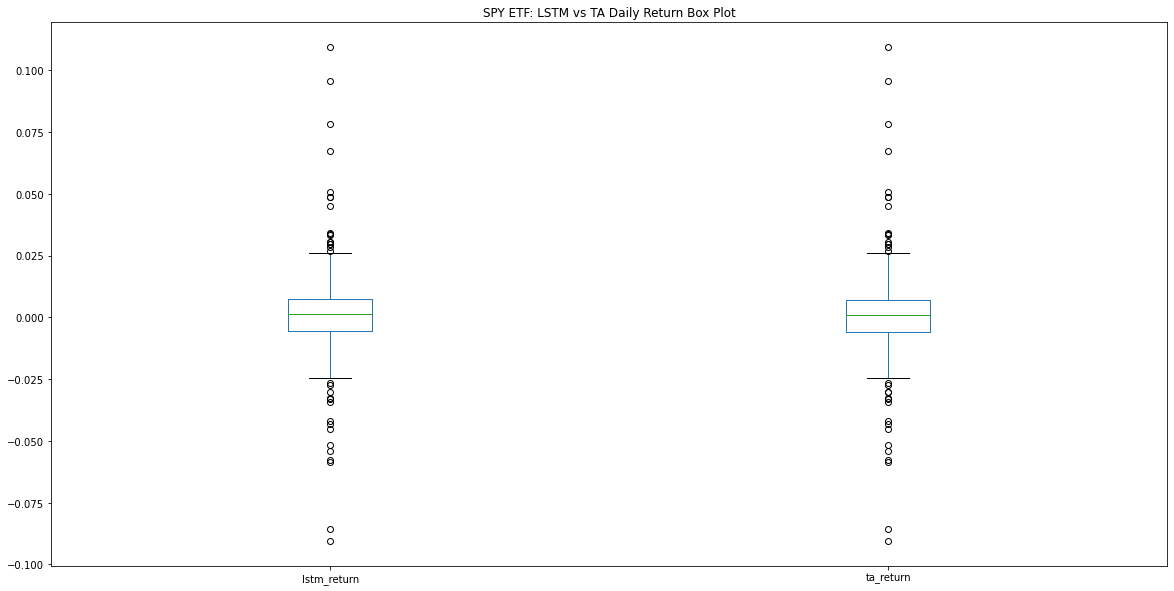

In [84]:
temp_df = pd.concat([lstm_col, signals_col], axis=1)
temp_df.plot.box(figsize=(20, 10), title="SPY ETF: LSTM vs TA Daily Return Box Plot") 

In [85]:
lstm_col = Predicted_LSTM['lstm_return'].copy()
signals_col = signals_df['ta_return'].copy()



print(f"LSTM Stdev: {Predicted_LSTM['lstm_return'].std()}")
print(f"TA Stdev: {signals_df['ta_return'].std()}")

LSTM Stdev: 0.01590418354214906
TA Stdev: 0.015942181371823804


In [86]:
lstm_stdev = (np.sqrt(252)*Predicted_LSTM['lstm_return']).rolling(window=63).std()
lstm_stdev = lstm_stdev.dropna()


In [87]:
ta_stdev = (np.sqrt(252)*signals_df['ta_return']).rolling(window=63).std()
ta_stdev =ta_stdev.dropna()

<AxesSubplot:title={'center':'SPY 3m Rolling Volatility'}, xlabel='date'>

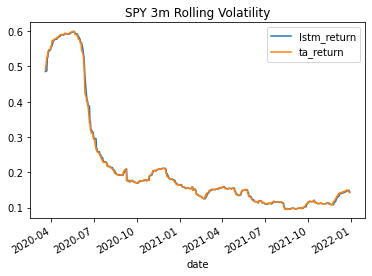

In [71]:
plot_df = pd.concat([lstm_stdev, ta_stdev], axis=1).dropna()
plot_df.plot(title= 'SPY 3m Rolling Volatility')

In [72]:
lstm_col = Predicted_LSTM['lstm_return'].copy()
signals_col = signals_df['ta_return'].copy()

<AxesSubplot:title={'center':'SPY Returns'}, xlabel='date'>

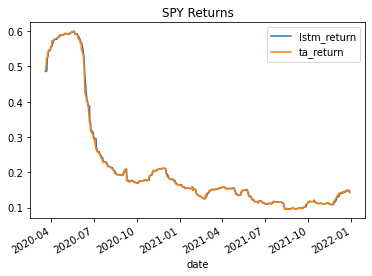

In [73]:
plot_df.plot(title= 'SPY Returns')

In [74]:
lstm_col = Predicted_LSTM['lstm_return'].copy()
signals_col = signals_df['ta_return'].copy()

In [75]:
concats = pd.concat([lstm_col, signals_col], axis = 1) # axis = 0 if error
concats.to_csv("PREDICTIONS.csv")

## Use pyfolio to compare LSTM and TA results


In [76]:
# remove your installed pyfolio library
#!pip uninstall pyfolio

# Install it again from its github repo
#!pip install git+https://github.com/quantopian/pyfolio

#!pip install pyfolio==0.9.2

#pip install empyrical==0.3.4


In [77]:
import pyfolio as pf

### LSTM Return Result

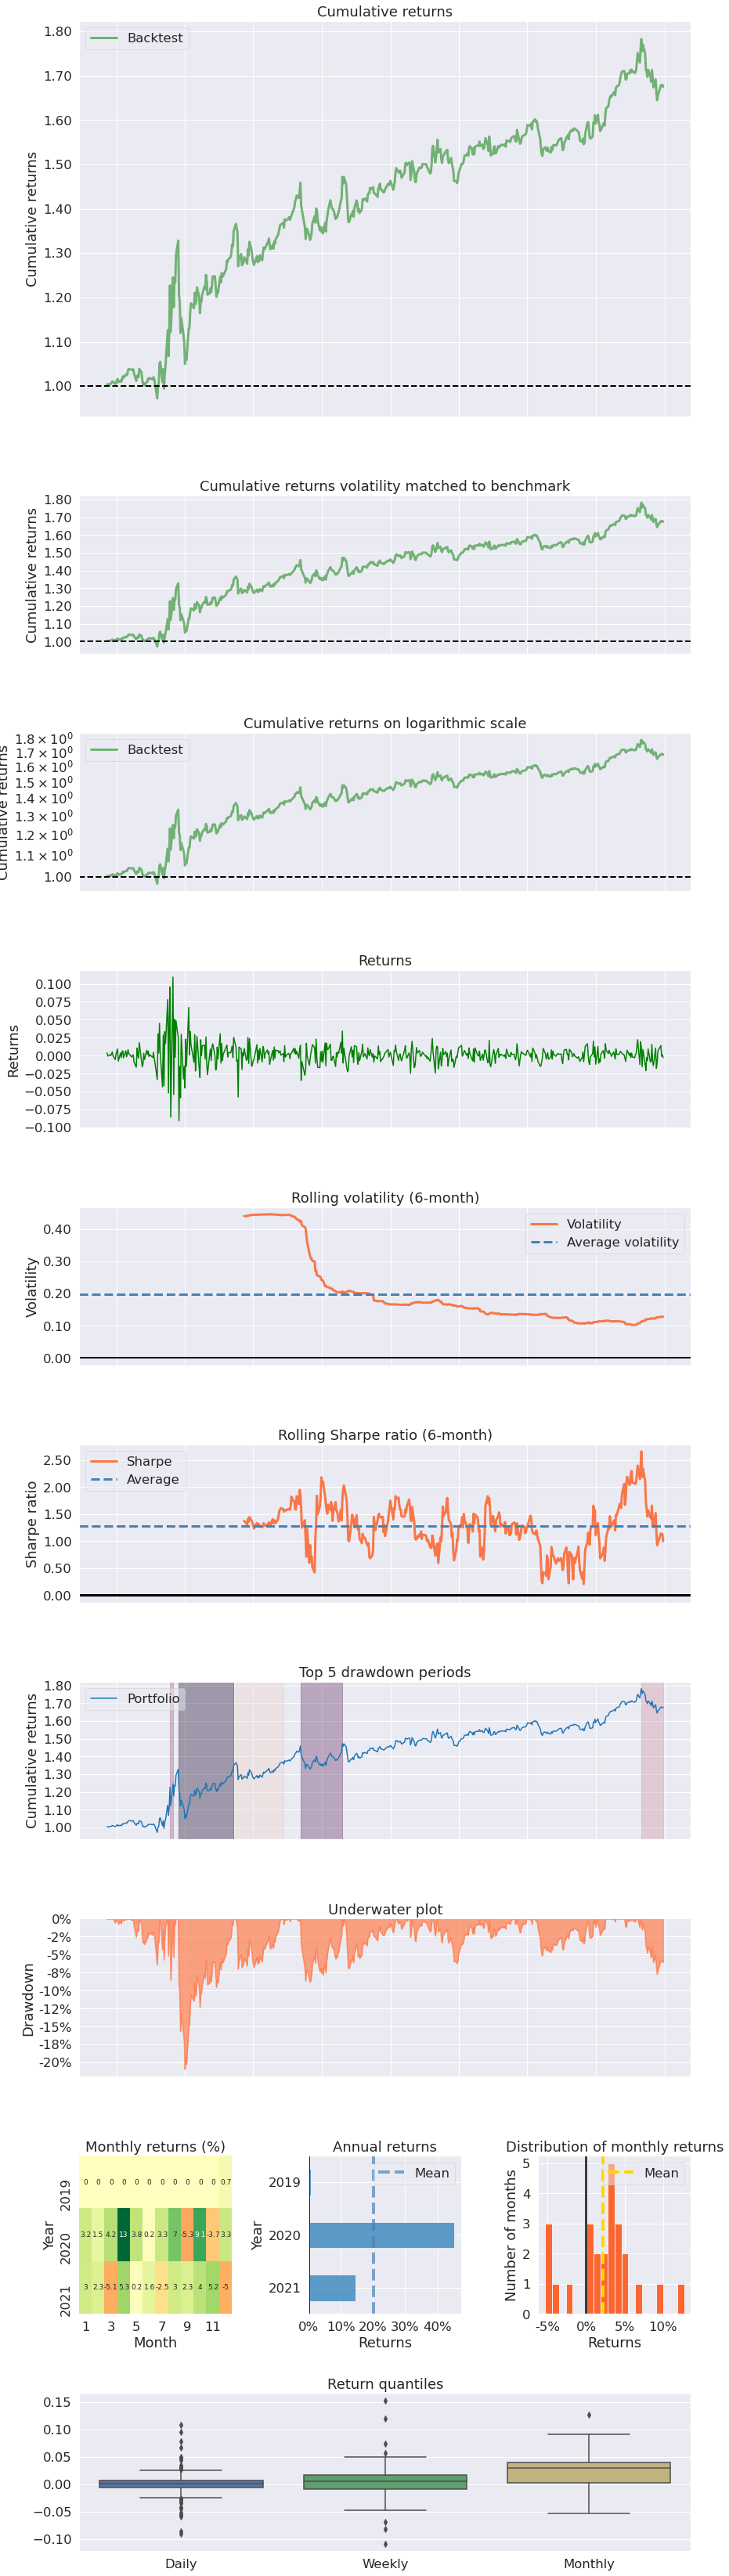

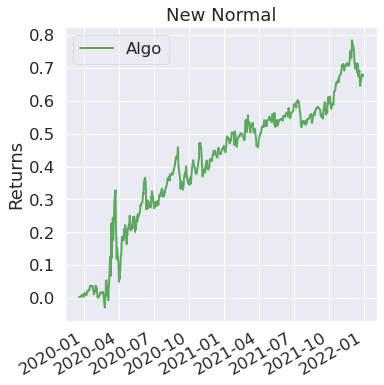

In [78]:
pf.create_full_tear_sheet(Predicted_LSTM['lstm_return'])

### Technical Analysis pyfolio Result

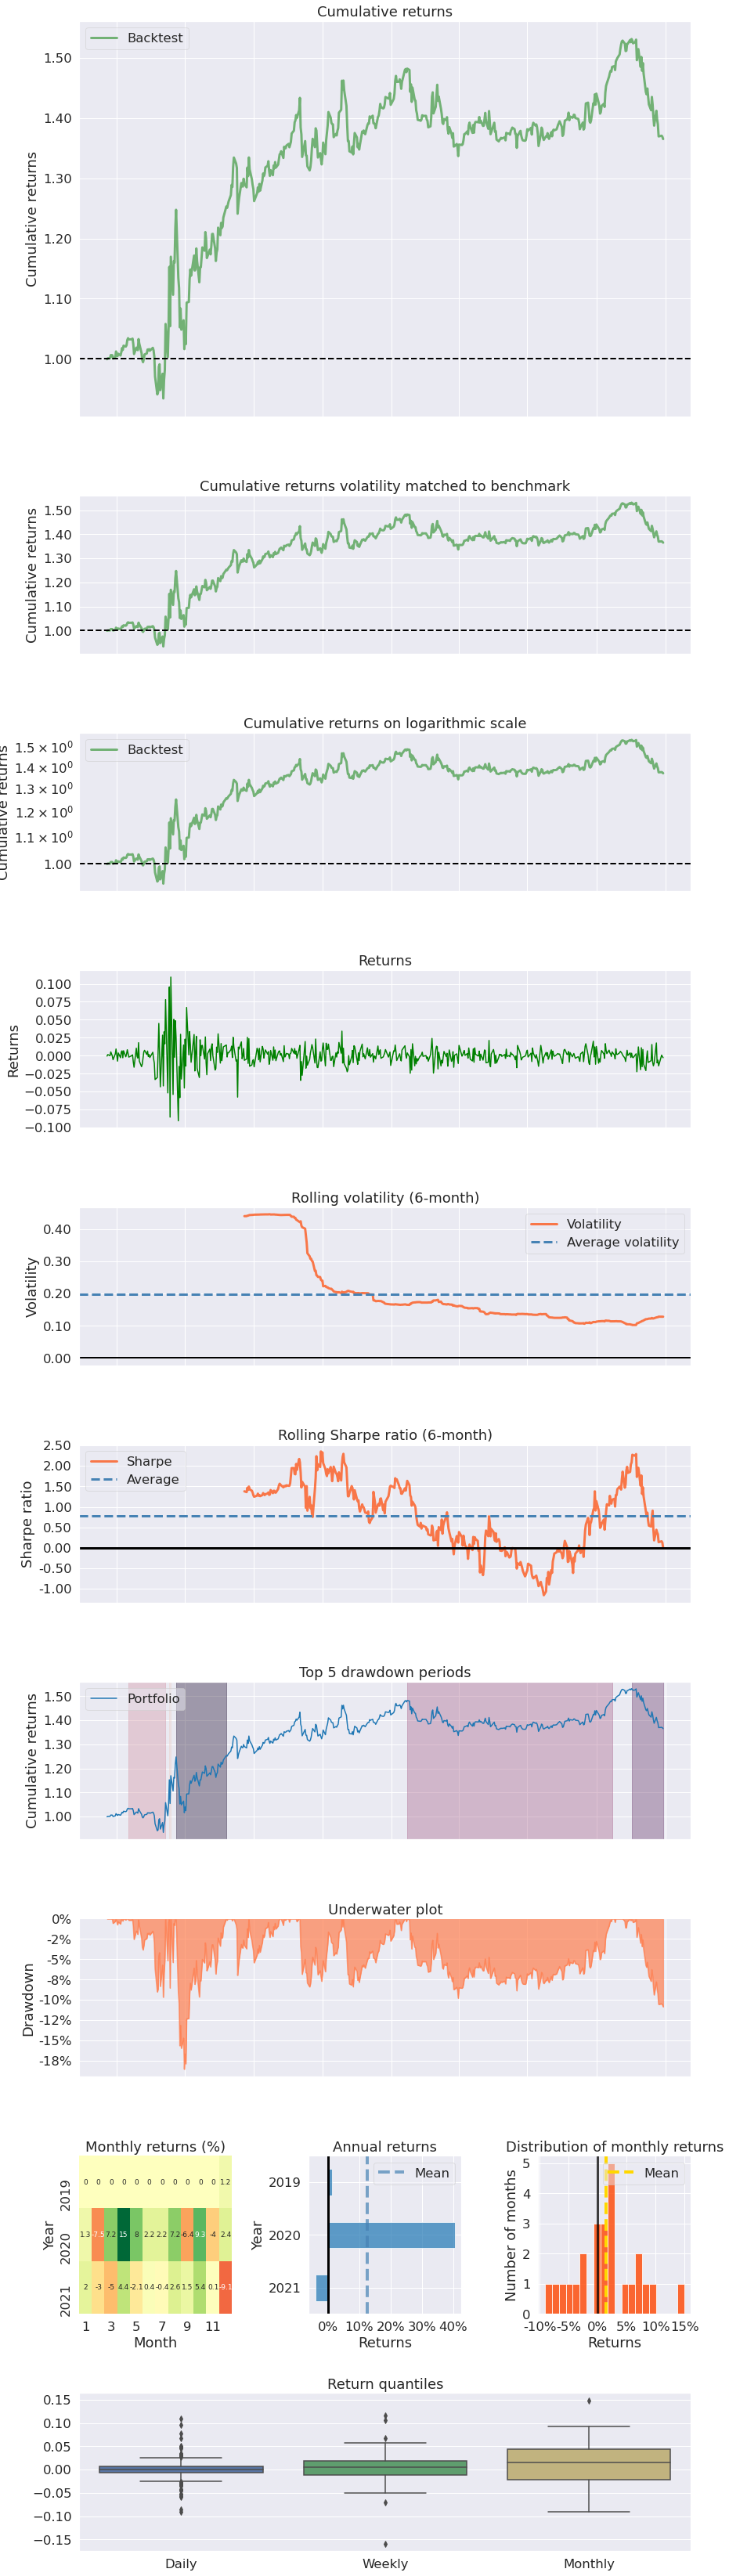

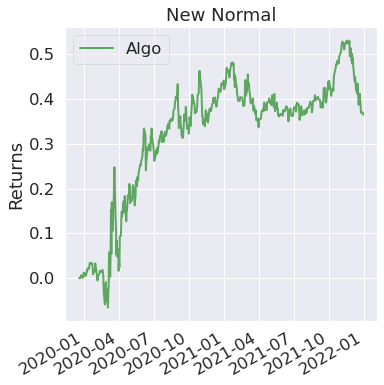

In [79]:
pf.create_full_tear_sheet(signals_df['ta_return'])